In [1]:
import math
import numpy as np
import cv2
from dataclasses import dataclass, asdict

In [2]:
from ipynb.fs.full.CalibratedObserver import CalibratedCaptureConfiguration, CalibratedObserver, MiniMapObject, TrackedObject, CameraChange

In [3]:
@dataclass
class HexGridConfiguration:
    size: float = 38
    rotation_deg: float = 0
    offset_xy: tuple = (0, 0)
    anchor_xy: tuple = (-12, -19)
    width: int = 1600
    height: int = 1600

    def __post_init__(self):
        self.anchor_xy = (-int((self.size / 2.86) + 0.25), -int(self.size / 2))

In [4]:
class HexCaptureConfiguration(CalibratedCaptureConfiguration):
    def loadConfiguration(self, path="observerConfiguration.json"):
        super().loadConfiguration()
        try:
            config = self.readConfigFile()
        except Exception:
            config = {}
        self.hex = config.get("hex", None)
        if self.hex is not None:
            self.hex = HexGridConfiguration(**self.hex)

    def buildConfiguration(self):
        config = super().buildConfiguration()
        if self.hex is not None:
            config['hex'] = asdict(self.hex)
        return config

    def axial_to_pixel(self, q: float, r: float) -> np.ndarray:
        """
        Axial (q, r) → grid-space pixel (x, y), pointy-top hexes
        """
        x = self.hex.size * math.sqrt(3) * (q + r / 2.0)
        y = self.hex.size * 1.5 * r
        center = np.array([[x, y]], dtype=np.float32)
        center_p = self.apply_affine_pts(center)[0]
        return np.array([x, y], dtype=np.float32)

    @staticmethod
    def axial_round(q: float, r: float) -> tuple[int, int]:
        """
        Round fractional axial coords to nearest hex
        """
        x = q
        z = r
        y = -x - z
    
        rx = round(x)
        ry = round(y)
        rz = round(z)
    
        dx = abs(rx - x)
        dy = abs(ry - y)
        dz = abs(rz - z)
    
        if dx > dy and dx > dz:
            rx = -ry - rz
        elif dy > dz:
            ry = -rx - rz
        else:
            rz = -rx - ry
    
        return int(rx), int(rz)

    @staticmethod
    def pixel_to_axial_frac(x: float, y: float, size: float) -> tuple[float, float]:
        """
        Grid-space pixel → fractional axial (q, r)
        """
        r = (2.0 / 3.0) * (y / size)
        q = (x / (math.sqrt(3) * size)) - (r / 2.0)
        return q, r
    
    def pixel_to_axial(
        self,
        px: float, py: float
    ) -> tuple[int, int]:
        """
        Image pixel → axial hex (q, r)
        """
        # Invert affine (2x3 → 3x3)
        M = self.make_affine_2x3()
        M3 = np.vstack([M, [0, 0, 1]])
        M_inv = np.linalg.inv(M3)
    
        pt = np.array([[px, py, 1.0]], dtype=np.float32).T
        gx, gy, _ = (M_inv @ pt).ravel()
    
        qf, rf = self.pixel_to_axial_frac(gx, gy, self.hex.size)
        return self.axial_round(qf, rf)

    def camCoordToAxial(self, cam, cam_coord: tuple[float]):
        real_coord = self.rsc.camCoordToRealSpace(cam, cam_coord)
        axial = self.pixel_to_axial(*real_coord)
        return axial

    def axialToCamCoord(self, cam, axial_coord: tuple[float]):
        real_coord = self.axial_to_pixel(*axial_coord)
        return self.rsc.realSpaceToCamCoord(real_coord, cam)

    def changeSetToAxialCoord(self, changeSet):
        real_coord = self.rsc.changeSetToRealCenter(changeSet)
        return self.pixel_to_axial(*real_coord)

    @staticmethod
    def axial_distance(a: tuple[int, int], b: tuple[int, int] = (0, 0)) -> int:
        q1, r1 = a
        q2, r2 = b
        return (abs(q1 - q2)
              + abs(q1 + r1 - q2 - r2)
              + abs(r1 - r2)) // 2

    def trackedObjectLastDistance(self, trackedObject):
        if trackedObject.isNewObject:
            return 0
        previousChangeSet = trackedObject.previousVersion()
        current_axial = self.changeSetToAxialCoord(trackedObject)
        previous_axial = self.changeSetToAxialCoord(previousChangeSet)
        return self.axial_distance(current_axial, previous_axial)

    def make_affine_2x3(self) -> np.ndarray:
        ax, ay = self.hex.anchor_xy
        tx, ty = self.hex.offset_xy
        theta = math.radians(self.hex.rotation_deg)
        c = math.cos(theta)
        s = math.sin(theta)
    
        a11 = c
        a12 = -s
        a21 = s
        a22 = c
    
        # p' = A(p - anchor) + anchor + offset = A p + (anchor + offset - A anchor)
        b1 = ax + tx - (a11 * ax + a12 * ay)
        b2 = ay + ty - (a21 * ax + a22 * ay)
    
        return np.array([[a11, a12, b1],
                         [a21, a22, b2]], dtype=np.float32)

    def apply_affine_pts(self, pts_xy: np.ndarray) -> np.ndarray:
        """
        pts_xy: (N,2) float array
        returns: (N,2) float array
        """
        M = self.make_affine_2x3()
        x = pts_xy[:, 0]
        y = pts_xy[:, 1]
        xp = M[0, 0] * x + M[0, 1] * y + M[0, 2]
        yp = M[1, 0] * x + M[1, 1] * y + M[1, 2]
        return np.stack([xp, yp], axis=1)

    def hex_offsets_pointy(self) -> np.ndarray:
        """
        Corner offsets for a pointy-top hex centered at origin in *grid space*.
        Returns (6,2) float offsets.
        """
        offs = []
        for k in range(6):
            ang = math.radians(60 * k - 30)  # pointy-top
            offs.append([self.hex.size * math.cos(ang), self.hex.size * math.sin(ang)])
        return np.array(offs, dtype=np.float32),
    
    def draw_hex_grid_overlay(
        self,
        base_img: np.ndarray,
        x0: int, y0: int, w: int, h: int,
        *,
        color: tuple[int, int, int] = (255, 255, 255),
        thickness: int = 3,
        alpha: float = 1.0
    ) -> np.ndarray:
        """
        Draw a pointy-top hex grid over bbox [x0:x0+w, y0:y0+h] with
        scale/rotation/offset applied consistently to BOTH centers and corners.
        """
        overlay = self.draw_grid(color=color, thickness=thickness)
    
        # Blend only inside bbox
        out = base_img.copy()
        roi = out[y0:y0+h, x0:x0+w]
        roi_overlay = overlay[y0:y0+h, x0:x0+w]
        cv2.addWeighted(roi_overlay, alpha, roi, 1.0 - alpha, 0.0, dst=roi)
        out[y0:y0+h, x0:x0+w] = roi
        return out
        
    def draw_grid(
        self,
        color: tuple[int, int, int] = (80, 80, 80),
        thickness: int = 3
    ):
        # FIX: OpenCV expects (height, width, 3)
        overlay = np.zeros((self.hex.height, self.hex.width, 3), dtype=np.uint8)
    
        # If you need it computed for internal state, keep it; otherwise can remove.
        M = self.make_affine_2x3()
    
        dx = math.sqrt(3) * self.hex.size
        dy = 1.5 * self.hex.size
    
        corner_offs = self.hex_offsets_pointy()[0]  # (6,2) float offsets
    
        pad = 4.0 * self.hex.size
        xmin_g = self.hex.anchor_xy[0] - pad
        xmax_g = self.hex.anchor_xy[0] + self.hex.width + pad
        ymin_g = self.hex.anchor_xy[1] - pad
        ymax_g = self.hex.anchor_xy[1] + self.hex.height + pad
    
        row = 0
        cy_g = ymin_g
        while cy_g <= ymax_g:
            x_off = 0.0 if (row % 2 == 0) else (dx / 2.0)
            cx_g = xmin_g + x_off
            while cx_g <= xmax_g:
                center_g = np.array([[cx_g, cy_g]], dtype=np.float32)
    
                # Transform center for quick reject
                center_p = self.apply_affine_pts(center_g)[0]
    
                if (-200 <= center_p[0] <= self.hex.width + 200) and (-200 <= center_p[1] <= self.hex.height + 200):
                    # Build hex in grid space then transform corners
                    poly_g = corner_offs + center_g          # (6,2)
                    poly_p = self.apply_affine_pts(poly_g)   # (6,2) float in pixel space
    
                    # Optional: reject if polygon bbox is fully off-screen
                    minx, miny = poly_p.min(axis=0)
                    maxx, maxy = poly_p.max(axis=0)
                    if maxx < -5 or maxy < -5 or minx > self.hex.width + 5 or miny > self.hex.height + 5:
                        cx_g += dx
                        continue
    
                    poly_i = np.round(poly_p).astype(np.int32).reshape((-1, 1, 2))
    
                    cv2.polylines(
                        overlay,
                        [poly_i],
                        isClosed=True,
                        color=color,
                        thickness=thickness,
                        lineType=cv2.LINE_8
                    )
    
                cx_g += dx
            cy_g += dy
            row += 1
    
        return overlay

    def hex_at_axial(
        self,
        q: int,
        r: int
    ):
        """
        Fill a single pointy-top hex at axial coordinate (q, r) and return polygon points in grid coordinates.
    
        img               : OpenCV image to draw into (H, W, 3)
        q, r              : axial hex coordinates
        hex_size          : distance from hex center to corner (in grid space)
        color             : BGR color
        apply_affine_pts  : optional function (N,2)->(N,2) to map grid→pixel space
                             (use the same one as your grid renderer)
        """

        adjust = int(self.hex.size / 2)
        center = self.axial_to_pixel(q, r)
        cx, cy = center
    
        # --- hex corner offsets (pointy-top) ---
        corners = []
        for k in range(6):
            ang = math.radians(60 * k - 30)
            corners.append([
                cx + self.hex.size * math.cos(ang),
                cy + self.hex.size * math.sin(ang),
            ])
    
        poly = np.array(corners, dtype=np.float32)
        poly = self.apply_affine_pts(poly)
    
        poly_i = np.round(poly).astype(np.int32).reshape((-1, 1, 2))
        return poly_i

    def cam_hex_at_axial(self, cam, q: int, r: int):
        w, h = self.cameras[cam].mostRecentFrame.shape[:2]
        cam_space_converter = self.rsc.converters[cam][0]
        M = cam_space_converter.M
        Minv = np.linalg.inv(M)
        grid_poly = self.hex_at_axial(q, r)
        cam_poly = np.array([[int(d) for d in cam_space_converter.convertRealToCameraSpace(p[0])] for p in grid_poly], dtype="int32")
        return cam_poly

    def buildMiniMap(self, objectsAndColors: list["MiniMapObject"], hex_cfg = None):
        image = self.draw_hex_grid_overlay(
            np.zeros([1200, 1200, 3], dtype="uint8"), 0, 0, 1200, 1200
        )
        if self.rsc is None:
            return image

        cv2.drawContours(image, self.realSpaceContours, -1, (125, 125, 125), 6)
    
        drawnObjs = []
        for objAndColor in objectsAndColors[::-1]:
            obj = objAndColor.object
            color = objAndColor.color
            if obj in drawnObjs:
                continue
            drawnObjs.append(obj)
            hull = self.objectToHull(obj)
            image = cv2.drawContours(image, [hull], -1, color, -1)
    
        return image

    def changeSetToAxial(self, changeSet):
        return self.pixel_to_axial(*self.rsc.changeSetToRealCenter(changeSet))

    def cameraGriddle(self, cam, objectsAndColors=[]):
        w, h = self.cameras[cam].mostRecentFrame.shape[:2]
        M = self.rsc.converters[cam][0].M
        Minv = np.linalg.inv(M)

        if self.rsc is None:
             return np.zeros((w,h,3), dtype="uint8")

        warped = cv2.warpPerspective(
            self.buildMiniMap(objectsAndColors=objectsAndColors),
            Minv,
            (h, w),
            flags=cv2.INTER_NEAREST,
            borderMode=cv2.BORDER_CONSTANT,
            borderValue=(0, 0, 0),
        )
        return warped[:w, :h]
        
    def griddleCameras(self, objectsAndColors=[], alpha=0.3):
        blended = {}
        img = self.buildMiniMap(objectsAndColors=objectsAndColors)
        
        if self.rsc is None:
            return {}

        for cam in self.cameras.keys():
            cameraChanges = self.cameras[cam].cropToActiveZone(self.cameras[cam].mostRecentFrame.copy())
            w, h = cameraChanges.shape[:2]
            M = self.rsc.converters[cam][0].M
            Minv = np.linalg.inv(M)
    
            # Use nearest for crisp overlays; use linear for smoother images
            warped = cv2.warpPerspective(
                img,
                Minv,
                (h, w),
                flags=cv2.INTER_NEAREST,
                borderMode=cv2.BORDER_CONSTANT,
                borderValue=(0, 0, 0),
            )
            blended[cam] = self.cameras[cam].cropToActiveZone(cv2.addWeighted(warped[:w, :h], alpha, cameraChanges, 1.0 - alpha, 0.0))
        return blended

    def axialDistanceBetweenObjects(self, changeSetA, changeSetB):
        real_coord_a = self.rsc.changeSetToRealCenter(changeSetA)
        real_coord_b = self.rsc.changeSetToRealCenter(changeSetB)
        axial_coord_a = self.pixel_to_axial(*real_coord_a)
        axial_coord_b = self.pixel_to_axial(*real_coord_b)
        return self.axial_distance(axial_coord_a, axial_coord_b)

    def define_object_from_axial(self, oid, q, r):
        if self.rsc is None:
            raise Exception("Cannot define an object without a RealSpace Configuration")

        realSpacePoly = self.hex_at_axial(q, r)

        changeSet = {}
        for cam in self.cameras.keys():
            cam_poly = np.array([[int(d) for d in self.rsc.converters[cam][0].convertRealToCameraSpace(p[0])] for p in realSpacePoly], dtype="int32")
            changeSet[cam] = CameraChange(
                camName=cam,
                changeContours=[cam_poly.reshape((-1, 1, 2))],
                before=self.cameras[cam].mostRecentFrame,
                after=self.cameras[cam].mostRecentFrame,
                changeType = "add",
                lastChange = None,
            )
        
        return TrackedObject(oid=oid, changeSet=changeSet)

    def define_object_from_axials(self, oid: str, axials: list[tuple[int]]):
        if self.rsc is None:
            raise Exception("Cannot define an object without a RealSpace Configuration")
        if not axials:
            raise ValueError("axials must be non-empty")
    
        changeSet = {}
    
        for cam in self.cameras.keys():
            conv = self.rsc.converters[cam][0]
    
            # Use current frame size for the mask
            frame = self.cameras[cam].mostRecentFrame
            if frame is None:
                raise Exception(f"No mostRecentFrame for camera {cam}")
            H, W = frame.shape[:2]
    
            mask = np.zeros((H, W), dtype=np.uint8)
    
            # 1) Project each axial hex to camera space and fill it into the mask
            for (q, r) in axials:
                real_hex = self.hex_at_axial(q, r)  # iterable of points, often (6,1,2) or (6,2)
    
                cam_pts = []
                for p in real_hex:
                    p = p[0] if (hasattr(p, "__len__") and len(p) == 1 and len(p[0]) == 2) else p
                    px, py = conv.convertRealToCameraSpace((p[0], p[1]))
                    cam_pts.append([int(round(px)), int(round(py))])
    
                poly = np.array(cam_pts, dtype=np.int32).reshape((-1, 1, 2))
                cv2.fillPoly(mask, [poly], 255)
    
            # 2) Extract contours with hierarchy so holes are preserved
            # RETR_CCOMP gives a two-level hierarchy: outer contours + hole contours.
            contours, hierarchy = cv2.findContours(mask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    
            if not contours:
                # No pixels filled (maybe all projected off-frame)
                changeContours = []
            else:
                # Optional: simplify contours a bit (reduce jaggies)
                changeContours = []
                for cnt in contours:
                    if len(cnt) < 3:
                        continue
                    # epsilon in pixels; tweak if needed
                    eps = 1.0
                    approx = cv2.approxPolyDP(cnt, eps, closed=True)
                    if len(approx) >= 3:
                        changeContours.append(approx.astype(np.int32))
    
            changeSet[cam] = CameraChange(
                camName=cam,
                changeContours=changeContours,
                before=frame,
                after=frame,
                changeType="add",
                lastChange=None,
            )
    
        return TrackedObject(oid=oid, changeSet=changeSet)

    0 -- CapMac -- passive idle


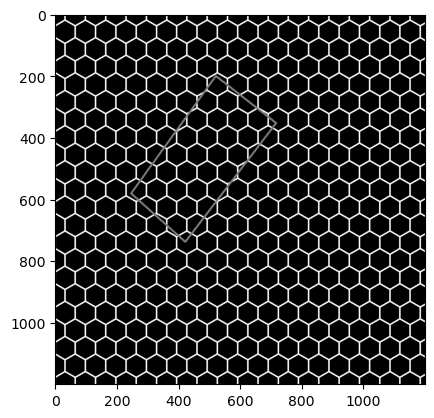

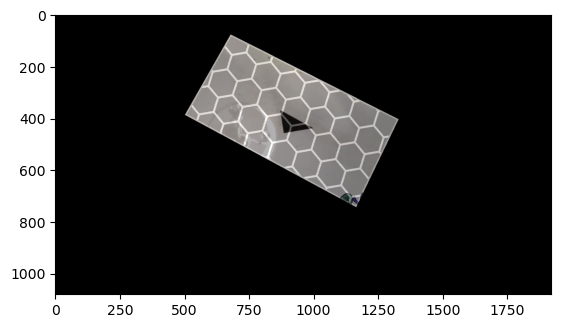

In [5]:
if __name__ == "__main__":
    import matplotlib.pyplot as plt 
    hc = HexCaptureConfiguration()
    hc.hex = HexGridConfiguration()
    co = CalibratedObserver(hc)
    co.cycle()
    plt.imshow(co.buildMiniMap(objectsAndColors=[MiniMapObject(mem, (255, 0, 0)) for mem in co.memory]))
    plt.show()
    # for i in range(2):
    #     co.cycleForChange()
    #     plt.imshow(co.buildMiniMap(objectsAndColors=[MiniMapObject(mem, (255, 0, 0)) for mem in co.memory]))
    #     plt.show()
    # a = hc.changeSetToAxial(co.memory[0])
    # b = hc.changeSetToAxial(co.memory[1])
    # print(f"Axial Distance between objects: {hc.axial_distance(a, b)}")
    img = hc.griddleCameras(objectsAndColors=[MiniMapObject(mem, (255, 0, 0)) for mem in co.memory])['0']
    plt.imshow(img)

    try:
        foo = hc.define_object_from_axial("foo", -1, 9)
    except Exception as e:
        print(f"Failed: {e}")